# Introduction

This notebook tackles the [**Playground Series – Season 5, Episode 10: Predicting Loan Payback**](https://www.kaggle.com/competitions/playground-series-s5e11), a competition focused on a common financial task: assessing credit risk. The goal is to develop a **binary classification model** that can accurately predict the **probability** a borrower will pay back their loan, based on a set of financial and demographic features.

### The Approach

To achieve this, we will follow a structured machine learning workflow:

1.  **Exploratory Data Analysis (EDA):** We will begin by conducting a deep dive into the dataset using `ydata_profiling` and custom visualizations. This will help us understand the data's structure, identify patterns, analyze feature distributions, check for correlations, and assess overall data quality.
    
2.  **Data Preprocessing & Feature Engineering:** Based on insights from the EDA, we will prepare the data for modeling. This will involve encoding categorical variables (like `education_level` and `marital_status`) and splitting combined features (like `grade_subgrade`) to extract maximum predictive value.
    
3.  **Model Development& Tuning:** We will build and train a robust predictive model. Given the tabular nature of the data, we will focus on a **LightGBM** (Light Gradient Boosting Machine) model, renowned for its high performance and efficiency. We will also leverage **Optuna** for automated hyperparameter tuning to find the best-performing model configuration.
    
4.  **Submission:** Finally, we will use our tuned model to generate predictions (probabilities) on the test set and format them into a `submission.csv` file for the competition.
    
Let's begin by loading the necessary libraries and exploring the data.

In [1]:
!pip install sweetviz
%pip install --no-binary lightgbm --config-settings=cmake.define.USE_CUDA=ON lightgbm
%pip -q install -U optuna
%pip -q install optuna-integration[lightgbm]
%pip -q install --upgrade ydata_profiling


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import math
import random
import warnings
from pathlib import Path
from contextlib import contextmanager
from time import time
from typing import Iterable
from IPython.display import display, Markdown, IFrame

# --- Third-party
import numpy as np
import pandas as pd
from IPython.display import display
from ydata_profiling import ProfileReport
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# --- Notebook settings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# Define some utilities functions
def configure_notebook(seed: int = 10301, float_precision: int = 3, max_columns: int = 15, max_rows: int = 25) -> int:
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

def running_in_kaggle() -> bool:
    """
    Heuristics that are true in Kaggle notebooks:
    - Special directories exist (/kaggle/input, /kaggle/working)
    - Env var KAGGLE_KERNEL_RUN_TYPE is set
    - The kaggle_secrets module is available
    """
    try:
        if os.path.isdir("/kaggle/input") and os.path.isdir("/kaggle/working"):
            return True
        if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
            return True
        import kaggle_secrets  # noqa: F401  (only exists in Kaggle)
        return True
    except Exception:
        return False

# Use a context manager to suppress standard error output
# This is a robust way to handle warnings that bypass Python's warnings module
class SuppressStderr:
    def __enter__(self):
        self.original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self.original_stderr

In [4]:
# Apply configuration and set random seeds for reproducibility
seed = configure_notebook(max_columns = None, max_rows = None)    

#### Read the training data and display a bit of it

In [5]:
DATA_DIR = Path('/kaggle/input/playground-series-s5e11') if running_in_kaggle() else Path('data')

training_df = pd.read_csv(DATA_DIR / 'train.csv')
training_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,"29,367.990",0.084,736,"2,528.420",13.670,Female,Single,High School,Self-employed,Other,C3,1.000
1,1,"22,108.020",0.166,636,"4,593.100",12.920,Male,Married,Master's,Employed,Debt consolidation,D3,0.000
2,2,"49,566.200",0.097,694,"17,005.150",9.760,Male,Single,High School,Employed,Debt consolidation,C5,1.000
3,3,"46,858.250",0.065,533,"4,682.480",16.100,Female,Single,High School,Employed,Debt consolidation,F1,1.000
4,4,"25,496.700",0.053,665,"12,184.430",10.210,Male,Married,High School,Employed,Other,D1,1.000


#### Read the test data and display it

In [6]:
test_df = pd.read_csv(DATA_DIR / 'test.csv')
test_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,"28,781.050",0.049,626,"11,461.420",14.730,Female,Single,High School,Employed,Other,D5
1,593995,"46,626.390",0.093,732,"15,492.250",12.850,Female,Married,Master's,Employed,Other,C1
2,593996,"54,954.890",0.367,611,"3,796.410",13.290,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,"25,644.630",0.110,671,"6,574.300",9.570,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,"25,169.640",0.081,688,"17,696.890",12.800,Female,Married,PhD,Employed,Business,C1


#### Read the original data and display a bit of it

In [7]:
ORIGINAL_DIR = Path("/kaggle/input/loan-prediction-dataset-2025") if running_in_kaggle() else Path("original_data")

original_df = pd.read_csv(ORIGINAL_DIR / 'loan_dataset_20000.csv')
original_df.head()

,age,gender,marital_status,education_level,annual_income,monthly_income,employment_status,debt_to_income_ratio,credit_score,loan_amount,loan_purpose,interest_rate,loan_term,installment,grade_subgrade,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies,loan_paid_back
0,59,Male,Married,Master's,"24,240.190","2,020.020",Employed,0.074,743,"17,173.720",Car,13.390,36,581.880,B5,7,"40,833.470","24,302.070",1,0,1,1
1,72,Female,Married,Bachelor's,"20,172.980","1,681.080",Employed,0.219,531,"22,663.890",Debt consolidation,17.810,60,573.170,F1,5,"27,968.010","10,803.010",1,0,3,1
2,49,Female,Single,High School,"26,181.800","2,181.820",Employed,0.234,779,"3,631.360",Business,9.530,60,76.320,B4,2,"15,502.250","4,505.440",0,0,0,1
3,35,Female,Single,High School,"11,873.840",989.490,Employed,0.264,809,"14,939.230",Other,7.990,36,468.070,A5,7,"18,157.790","5,525.630",4,0,5,1
4,63,Other,Single,Other,"25,326.440","2,110.540",Employed,0.260,663,"16,551.710",Car,15.200,60,395.500,D5,1,"17,467.560","3,593.910",2,0,2,1


#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [8]:
training_df.drop('id', axis=1, inplace=True, errors = "ignore")

## Exploratory Data Analysis

In [9]:
# Create the profile report object for the TRAINING data
training_report = ProfileReport(training_df, title="Training Data")

# Create the profile report object for the TEST data
test_report = ProfileReport(test_df, title="Test Data")

# Create the comparison report
# This compares the test report *against* the train report
train_test_comparison_report = training_report.compare(test_report)

# Save the combined report to an HTML file
train_test_comparison_report.to_file("training_vs_test_comparison.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.93it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Display the HTML report in an iframe
IFrame(src='training_vs_test_comparison.html', width=1000, height=600)

In [11]:
# Create the profile report object for the ORIGINAL data
original_report = ProfileReport(original_df, title="Original Data")

# Create the comparison report
# This compares the test report *against* the train report
train_original_comparison_report = training_report.compare(original_report)

# Save the combined report to an HTML file
train_original_comparison_report.to_file("training_vs_original_comparison.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 26.29it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
# Display the HTML report in an iframe
IFrame(src='training_vs_original_comparison.html', width=1000, height=600)

### Initial Findings from EDA

Preliminary aanalysis and hypotheses for the dataset include::

*   **Data Quality:** The dataset appears to be well-structured and complete, with **no obvious missing values** in the initial rows. The `ydata_profiling` report will be used to confirm this across the entire dataset.
    
*   **Target Variable:** The target, `loan_paid_back`, is binary. A critical first step will be to check its distribution for **class imbalance**, as this will directly influence our model evaluation strategy (e.g., using AUC-ROC or F1-score over simple accuracy).
    
*   **Key Predictors:** It appears that financial health indicators like `credit_score`, `interest_rate`, `debt_to_income_ratio`, and the lender-assigned `grade_subgrade` will be the strongest predictors of loan payback.
    
*   **Distribution Consistency:** We will pay close attention to the similarity between feature distributions in the training and test sets. Consistent distributions are key to building a model that generalizes well and avoids overfitting.

# Data Visualization

#### Feature Relationships & Target Variable Analysis
We will visually explore the dataset to understand how each feature relates to our target variable, `loan_paid_back`. This is a classification task, so our main goals are to:

*   **Analyze the Target:** First, we'll check the distribution of `loan_paid_back` to see if we have a **class imbalance** problem (e.g., far more people paid back than defaulted). This is critical as it impacts how we evaluate our model's performance.

*   **Numeric Features vs. Target:** We'll examine distributions of numeric features (like `credit_score`, `interest_rate`, and `annual_income`) for each target class (1.0 vs. 0.0). Significant differences in these distributions (e.g., in their median, spread, or shape) strongly suggest the feature is predictive.

*   **Categorical Features vs. Target:** We will analyze the payback rate across different categories (like `education_level`, `loan_purpose`, or `grade_subgrade`). This will quickly show us which categories are associated with a higher or lower risk of default.

These insights are crucial for guiding our feature engineering efforts and confirming which features are likely to be most important for the model.

In [13]:
TARGET = "loan_paid_back"
IS_CLASSIFICATION = training_df[TARGET].nunique() <= 10 and training_df[TARGET].dtype != float

In [14]:
def split_columns(df: pd.DataFrame, max_cardinality: int = 30):
    """
    Heuristic split into numeric vs categorical, with a cardinality cap for cats.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]
    
    # treat low-unique integer columns as categorical (IDs will be filtered later)
    for c in list(num_cols):
        if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique(dropna=True) <= max_cardinality:
            cat_cols.append(c)
            num_cols.remove(c)
            
    # drop high-cardinality cats from categorical plotting by default
    low_card_cats = [c for c in cat_cols if df[c].nunique(dropna=True) <= max_cardinality]
    
    return num_cols, low_card_cats
    
# short axis label helper
def colname(v):
    return str(v).replace("_", " ").title()

In [15]:
def collapse_rare_categories(s: pd.Series, min_count: int = 50) -> pd.Series:
    vc = s.value_counts()
    keep = vc[vc >= min_count].index
    return s.where(s.isin(keep), other="__OTHER__")

In [16]:
def categorical_vs_target_classification(df: pd.DataFrame, feature, target, min_count = 50, top_n = 20):
    s = collapse_rare_categories(df[feature].astype("object"), min_count=min_count)
    d = pd.DataFrame({feature: s, target: df[target]}).dropna()
    grp = d.groupby(feature)
    counts = grp.size().sort_values(ascending=False).head(top_n)
    cats = counts.index

    rate = grp[target].mean().reindex(cats)

    # counts
    plt.figure(figsize=(8, max(2, 0.35 * len(cats))))
    plt.barh([str(c) for c in cats], counts.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Count"); plt.title(f"{feature} – Top {len(cats)} Counts")
    plt.show()

    # target rates
    plt.figure(figsize=(8, max(2, 0.35 * len(cats))))
    plt.barh([str(c) for c in cats], rate.values)
    plt.gca().invert_yaxis()
    plt.xlabel(f"Mean {target}"); plt.title(f"{feature} – Target Rate (Top {len(cats)})")
    plt.show()

In [17]:
def has_target(df: pd.DataFrame, target:str):
    return target is not None and target in df.columns

In [18]:
def numeric_by_category_trend(df: pd.DataFrame, xcol:str, cat:str, target:str = TARGET, q:int = 15, min_count:int = 2000):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Keep frequent categories to reduce noise
    keep = df[cat].value_counts()
    keep = keep[keep >= min_count].index
    for k in keep:
        d = df[df[cat] == k][[xcol, target]].dropna()
        if d.empty or d[xcol].nunique() <2 : 
            continue
            
        bins = pd.qcut(d[xcol], q = min(q, d[xcol].nunique()), duplicates = "drop")
        m = d.groupby(bins)[target].mean()

        idx = m.index
        try:
            centers = idx.mid.to_numphy()
        except AttributeError:
            # fallback for very old pandas
            centers = np.array([(iv.left + iv.right) * 0.5 for iv in idx])
            
    plt.plot(centers, m.values, label = str(k))
    plt.title(f"{xcol} → mean({target}) by {cat}")
    plt.xlabel(xcol); 
    plt.ylabel(f"Mean {target}")
    plt.legend(loc="best")
    plt.show()

In [19]:
def cat_cat_heatmap(df: pd.DataFrame, cat1:str, cat2:str, target:str = TARGET, min_count:int = 500):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[cat1, cat2, target]].dropna()
    g = d.groupby([cat1, cat2])[target].agg(["mean", "count"]).reset_index()
    g = g[g["count"] >= min_count]
    if g.empty:
        print(f"[info] No {cat1}×{cat2} cells with count >= {min_count}.")
        return

    # Normalize labels ONCE to consistent strings
    s1 = g[cat1].astype("string").fillna("<NA>").astype(str)
    s2 = g[cat2].astype("string").fillna("<NA>").astype(str)

    # Stable ordering (by label) or by frequency if preferred
    rows, r_codes = np.unique(s1, return_inverse = True)
    cols, c_codes = np.unique(s2, return_inverse = True)

    A = np.full((len(rows), len(cols)), np.nan, dtype = float)
    A[r_codes, c_codes] = g["mean"].to_numpy()

    plt.figure(figsize=(1.2 * len(cols) + 2, 1.2 * len(rows) + 2))
    im = plt.imshow(A, aspect = "auto", origin = "upper")
    cbar = plt.colorbar(im, fraction = 0.046, pad = 0.04, label = f"Mean {target}")
    plt.xticks(np.arange(len(cols)), cols, rotation = 45, ha = "right")
    plt.yticks(np.arange(len(rows)), rows)
    plt.title(f"{cat1} × {cat2} → mean({target})")
    plt.tight_layout()
    plt.show()

In [20]:
def numeric_numeric_hex(df: pd.DataFrame, x:str, y:str, target:str = TARGET, gridsize:int = 50):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    d = df[[x, y, target]].dropna()
    plt.figure(figsize = (7, 5))
    hb = plt.hexbin(d[x].to_numpy(), d[y].to_numpy(), C=d[target].to_numpy(),
                    gridsize = gridsize, reduce_C_function = np.mean)
    plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} × {y} → mean({target})")
    cb = plt.colorbar(hb)
    cb.set_label(f"Mean {target}")
    plt.show()

In [21]:
# Feature signal ranking without modeling
def show_feature_signal_ranking(df: pd.DataFrame, target:str = TARGET):
    if not has_target(df, target):
        print(f"Dataframe doesn't have a target column {target}.")
        return
        
    # Spearman for numeric; ANOVA-style effect for categoricals
    num_cols = df.select_dtypes(include = [np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != target]

    scores = []
    for c in num_cols:
        s = df[[c, target]].dropna()
        if s.empty: continue
        rho, p = st.spearmanr(s[c], s[target])
        scores.append((c, float(rho)))
    scores = sorted(scores, key = lambda x: -abs(x[1]))
    print("Top numeric (|Spearman|):", scores[:10])

    cat_cols = [c for c in df.columns if c not in num_cols + [target]]
    effects = []
    for c in cat_cols:
        g = df.groupby(c, observed = True)[target].mean()
        if g.size >= 2:
            rng = float(g.max() - g.min())
            effects.append((c, rng, int(df[c].nunique())))
            
    effects = sorted(effects, key = lambda x: -x[1])
    print("Top categorical (range of mean risk):", effects[:10])

In [22]:
def plot_pairplot(df: pd.DataFrame, num_features: Iterable[str], target:str = TARGET):
    """
    Generates a pair plot for numerical features, colored by the target variable.
    """
    # Increase the 'height' parameter to make the overall plot larger.
    # A good starting point is around 3 to 5.
    sns.pairplot(df[num_features + [target]], hue=target, palette = 'viridis', height = 6)

    plt.suptitle('Pair Plot of Numerical Features', y=1.02)
    plt.show()
    
def plot_boxplots_grid(df: pd.DataFrame, cat_features: Iterable[str], target: str = TARGET, n_cols: int = 3):
    """
    Generates box plots for each categorical feature against the target variable
    in a n_cols -column grid.
    """
    # Define the grid dimensions
    n_features = len(cat_features)

    # Calculate the number of rows needed, using math.ceil to round up
    n_rows = math.ceil(n_features / n_cols)

    # Create the subplot grid
    # The figsize is increased to accommodate the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (18, n_rows * 5))

    # Flatten the axes array to make it easy to iterate over
    axes = axes.flatten()

    # Loop through the features and plot on the corresponding subplot
    for i, feature in enumerate(cat_features):
        ax = axes[i]
        sns.boxplot(x=feature, y=target, data=df, palette='viridis', ax = ax)
        ax.set_title(f'Box Plot of {target} by {feature}', fontsize = 12)
        ax.tick_params(axis = 'x', labelrotation = 45)

    # Hide any unused subplots
    # This is necessary if the number of features is not a perfect multiple of n_cols
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    # Adjust the layout to prevent titles and labels from overlapping
    plt.tight_layout()
    plt.show()

def plot_violinplots_grid(df: pd.DataFrame, cat_features: Iterable[str], target:str = TARGET, n_cols: int = 3):
    """
    Generates violin plots for each categorical feature against the target variable.
    in a n_cols -column grid.
    """
    # Define the grid dimensions
    n_features = len(cat_features)

    # Calculate the number of rows needed, using math.ceil to round up
    n_rows = math.ceil(n_features / n_cols)

    # Create the subplot grid
    # The figsize is increased to accommodate the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (18, n_rows * 5))

    # Flatten the axes array to make it easy to iterate over
    axes = axes.flatten()

    # Loop through the features and plot on the corresponding subplot
    for i, feature in enumerate(cat_features):
        ax = axes[i]
        sns.violinplot(x=feature, y=target, data = df, palette = 'viridis', ax = ax)
        ax.set_title(f'Violin Plot of {target} by {feature}', fontsize = 12)
        ax.tick_params(axis = 'x', labelrotation = 45)

    # Hide any unused subplots
    # This is necessary if the number of features is not a perfect multiple of n_cols
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    # Adjust the layout to prevent titles and labels from overlapping
    plt.tight_layout()
    plt.show()        

In [23]:
def _coerce_numeric_series(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s
    return pd.to_numeric(
        s.astype(str)
         .str.replace(r"[,\\$%]", "", regex=True)
         .str.replace(r"\\s+", "", regex=True)
         .replace({"n/a": np.nan, "na": np.nan, "-": np.nan, "": np.nan}),
        errors="coerce"
    )


def numeric_vs_target_classification(df: pd.DataFrame, numeric_col: str, target_col: str):
    """
    Plots the distribution of a single numeric feature against a categorical target
    using a boxplot and a violin plot.
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        numeric_col (str): The name of the numeric feature column.
        target_col (str): The name of the categorical target column.
    """
    
    # --- Input Validation ---
    if numeric_col not in df.columns:
        print(f"[warn] Numeric column '{numeric_col}' not in DataFrame. Skipping plot.")
        return
    if target_col not in df.columns:
        print(f"[warn] Target column '{target_col}' not in DataFrame. Skipping plot.")
        return

    # --- Data Preparation ---
    
    # Create a working copy
    plot_df = df[[numeric_col, target_col]].copy()
    
    # Coerce the numeric column to float, handling potential errors
    plot_df[numeric_col] = _coerce_numeric_series(plot_df[numeric_col])
    
    # Ensure target is treated as a category for plotting
    plot_df[target_col] = plot_df[target_col].astype('category')
    
    # Drop rows where either column is NaN (e.g., from coercion failure)
    plot_df = plot_df.dropna(subset=[numeric_col, target_col])

    if plot_df.empty:
        print(f"[warn] No valid data to plot for {numeric_col} vs {target_col}. Skipping.")
        return

    # --- Plotting ---
    try:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Boxplot
        sns.boxplot(x=target_col, y=numeric_col, data=plot_df, ax=axes[0], palette="viridis")
        axes[0].set_title(f'Boxplot of {numeric_col}')
        axes[0].set_xlabel(target_col)
        axes[0].set_ylabel(numeric_col)
        
        # Violin Plot
        sns.violinplot(x=target_col, y=numeric_col, data=plot_df, ax=axes[1], palette="viridis")
        axes[1].set_title(f'Violin Plot of {numeric_col}')
        axes[1].set_xlabel(target_col)
        axes[1].set_ylabel(numeric_col)
        
        fig.suptitle(f'{numeric_col} vs. {target_col} Distribution', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"[warn] Plotting failed for {numeric_col} vs {target_col}: {e}")

In [24]:
def is_discrete_numeric(s: pd.Series, max_unique:int = 20):
    return pd.api.types.is_numeric_dtype(s) and s.nunique(dropna = True) <= max_unique

def top_numeric_by_spearman(df: pd.DataFrame, num_cols: Iterable[str], target, k = 6):
    import scipy.stats as st
    scores = []
    for c in num_cols:
        d = df[[c, target]].dropna()
        if d.empty: 
            continue
            
        # skip all-constant / all-equal
        if d[c].nunique() < 2: 
            continue
            
        rho, _ = st.spearmanr(d[c], d[target])
        if np.isfinite(rho):
            scores.append((c, abs(float(rho))))
            
    scores.sort(key=lambda x: -x[1])
    return [c for c,_ in scores[:k]]

def top_categorical_by_range(df: pd.DataFrame, cat_cols: Iterable[str], target:str = TARGET, min_count:int = 200, k:int = 6):
    effects = []
    for c in cat_cols:
        d = df[[c, target]].dropna()
        if d.empty: 
            continue
            
        vc = d[c].value_counts()
        keep = set(vc[vc >= min_count].index)
        if not keep:
            continue
            
        m = d[d[c].isin(keep)].groupby(c)[target].mean()
        if m.size >= 2:
            effects.append((c, float(m.max() - m.min())))
            
    effects.sort(key=lambda x: -x[1])
    return [c for c,_ in effects[:k]]

In [25]:
def run_data_visualization(df: pd.DataFrame, target: str, max_cat_card: int = 30,
            heavy_sample: int = 150_000, num_count: int = 10, cat_count = 10):
    """
    Compact data_ isualization runner for mixed tabular data.
    - Uses new target-aware visuals when target is present.
    - Skips safely on test sets (no target).
    - Limits heavy plots to top-signal features.
    - Optionally downsamples for hexbin/heatmaps.
    """
    # Separate a version without target (works if target absent)
    df_wo_target = df.drop(columns = [target], errors = "ignore") if target else df

    # Split columns
    num_cols, cat_cols = split_columns(df_wo_target, max_cardinality = max_cat_card)
    
    # Treat booleans as categorical for plotting
    bool_cols = [c for c in df_wo_target.columns if pd.api.types.is_bool_dtype(df_wo_target[c])]
    cat_cols = sorted(set(cat_cols).union(bool_cols))

    # Target-aware (only if target present)
    if not has_target(df, target):
        print("Target not present → skipping target-aware plots.")
        return

    y = df[target]
    is_regression = pd.api.types.is_numeric_dtype(y) and y.nunique(dropna = True) > 20

    # Choose top features to keep plots readable and fast
    if is_regression:
        top_nums = top_numeric_by_spearman(df, [c for c in num_cols if c != target], target, k = num_count) or num_cols[:num_count]
        top_cats = top_categorical_by_range(df, cat_cols, target, min_count = 200, k = cat_count) or cat_cols[:cat_count]

        # Pair plots
        display(Markdown("### Pair Plots"))
        plot_pairplot(df, top_nums, target)

        # Box plots
        # Since violin plots show the same, skipping boxplots for now.
        # display(Markdown("### Box Plots"))
        # plot_boxplots_grid(df, top_cats, target)

        # Violin plots
        display(Markdown("### Violin Plots"))
        plot_violinplots_grid(df, top_cats, target)

        # Interactions (small set)
        # numeric × categorical (trend by category)
        if top_nums and top_cats:
            display(Markdown("### Numeric × Categorical (Trend By Category)"))
            numeric_by_category_trend(df, top_nums[0], top_cats[0], target = target, q = 15, min_count = 3000)

        # categorical × categorical (heatmap)
        if len(top_cats) >= 2:
            display(Markdown("### Categorical × Categorical (Heatmap)"))
            cat_cat_heatmap(df, top_cats[0], top_cats[1], target = target, min_count = 1000)

        # numeric × numeric (hexbin target mean)
        if len(top_nums) >= 2:
            display(Markdown("### Numeric × Numeric (Hexbin Target Mean)"))
            d_hex = df
            if heavy_sample is not None and len(df) > heavy_sample:
                d_hex = df.sample(heavy_sample, random_state = seed)
            numeric_numeric_hex(d_hex, top_nums[0], top_nums[1], target = target, gridsize = 50)

    else:
        # Classification-style (few unique target values)
        top_nums = [c for c in num_cols if c != target][:num_count]
        top_cats = cat_cols[:cat_count]

        for c in top_nums:
            try:
                numeric_vs_target_classification(df, c, target)
            except Exception as e:
                print(f"[warn] numeric(classif) plot failed for {c}: {e}")

        for c in top_cats:
            try:
                categorical_vs_target_classification(df, c, target, min_count = 100, top_n = 20)
            except Exception as e:
                print(f"[warn] categorical(classif) plot failed for {c}: {e}")

        # A couple of interactions
        if len(top_nums) and len(top_cats):
            display(Markdown("### Numeric x Category Trend"))
            numeric_by_category_trend(df, top_nums[0], top_cats[0], target = target, q = 12, min_count = 3000)
        if len(top_cats) >= 2:
            display(Markdown("### Category x Category Trend"))
            cat_cat_heatmap(df, top_cats[0], top_cats[1], target = target, min_count = 1500)

    display(Markdown("### Feature Signal Ranking"))
    show_feature_signal_ranking(df)

## Training Dataset Visualization

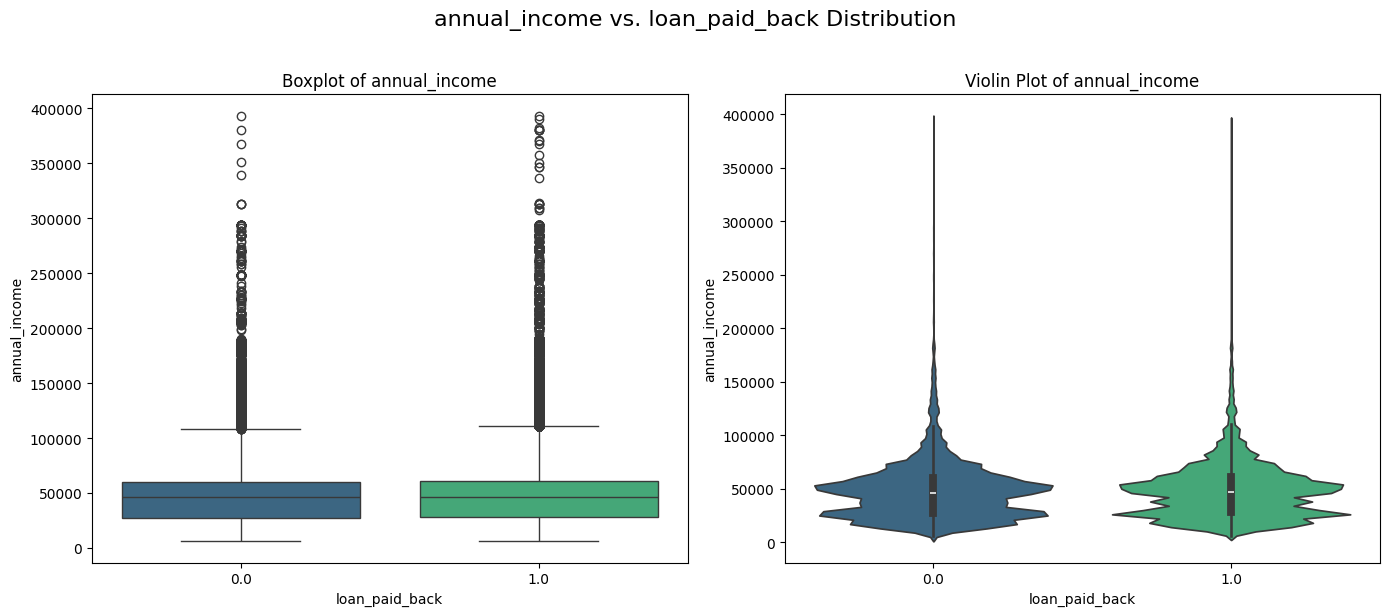

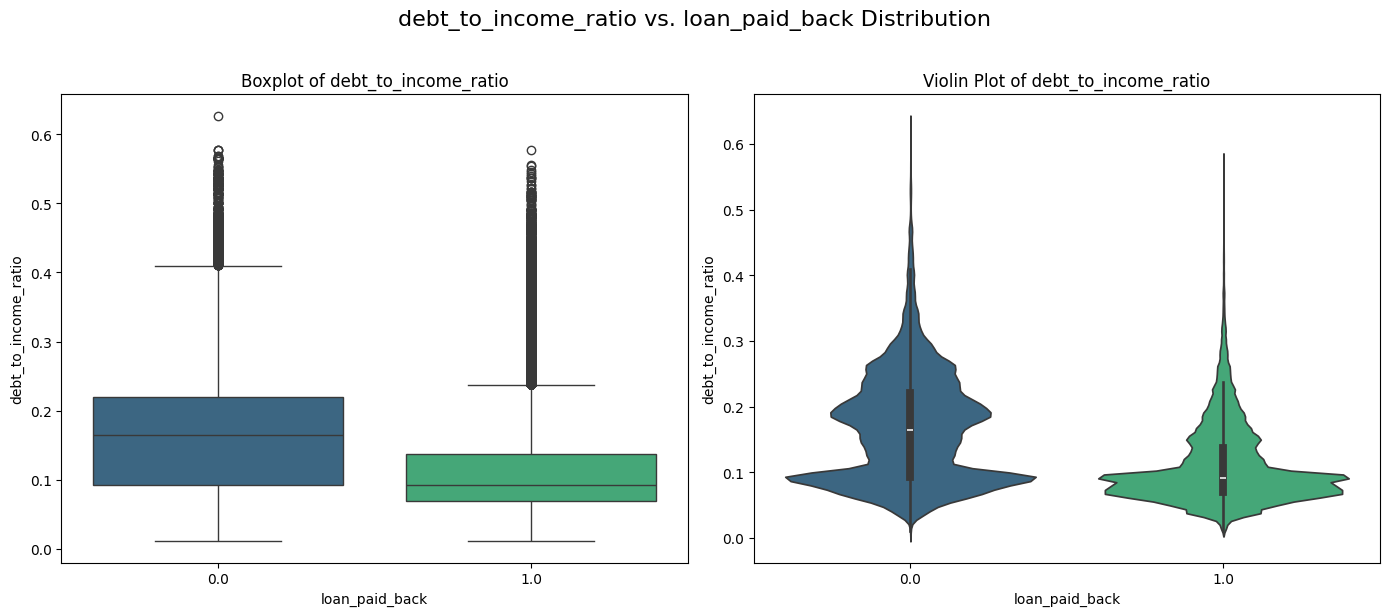

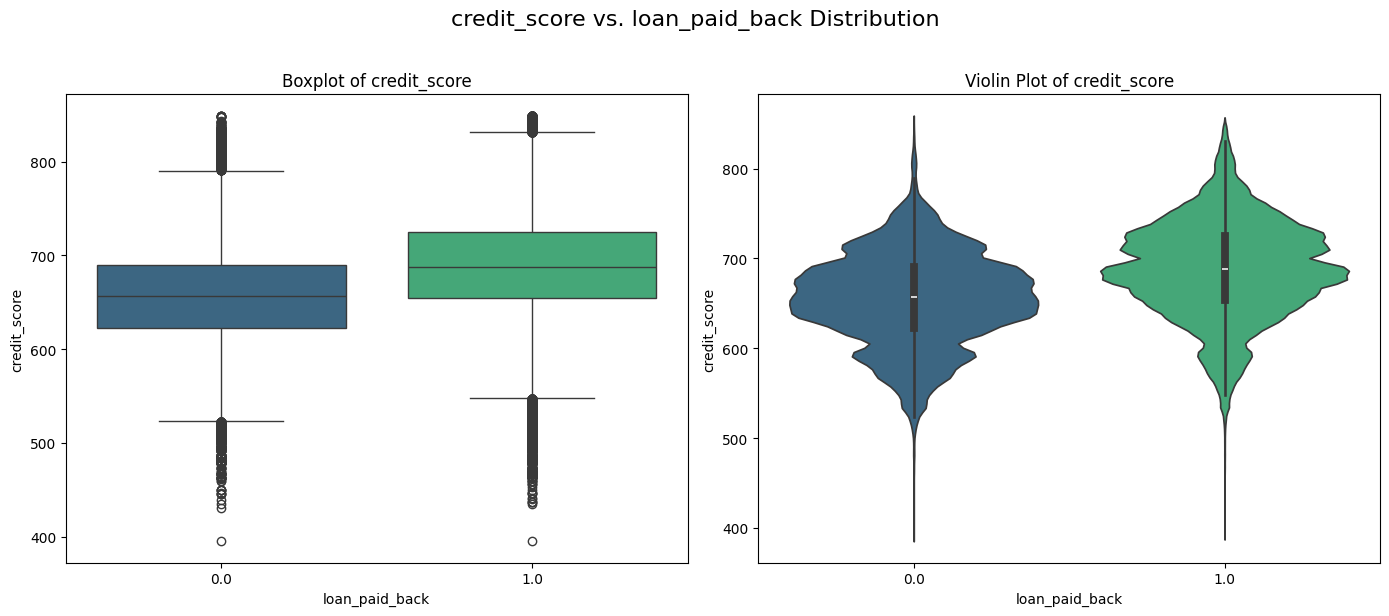

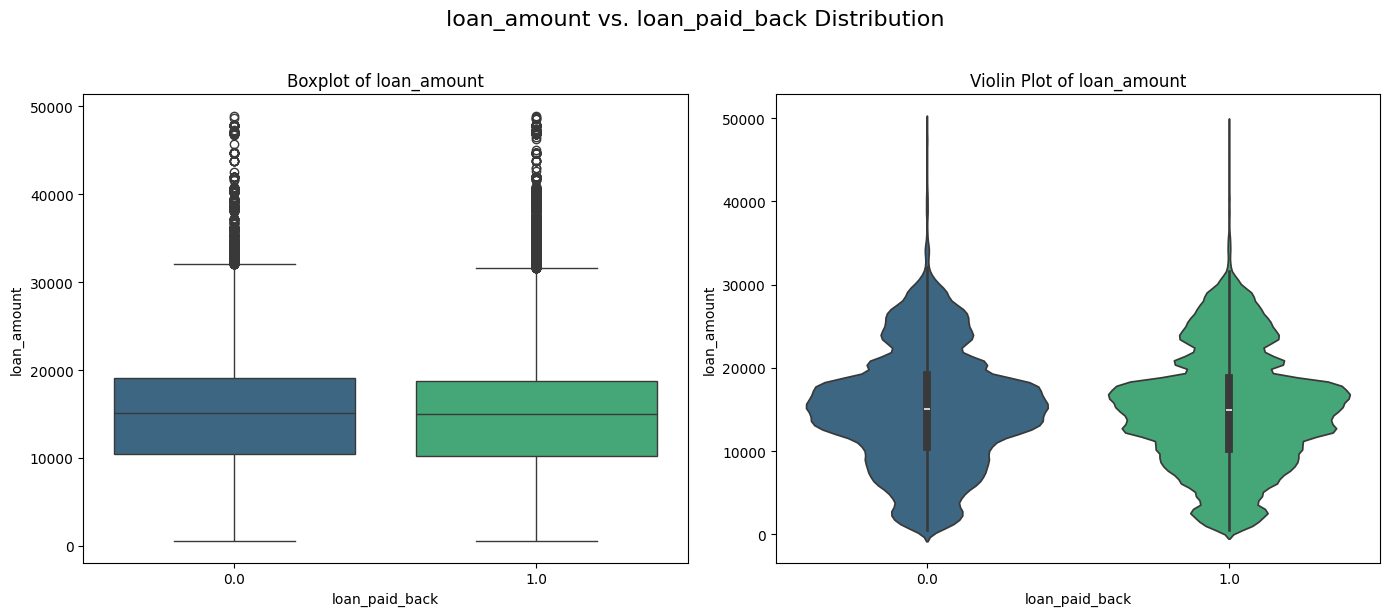

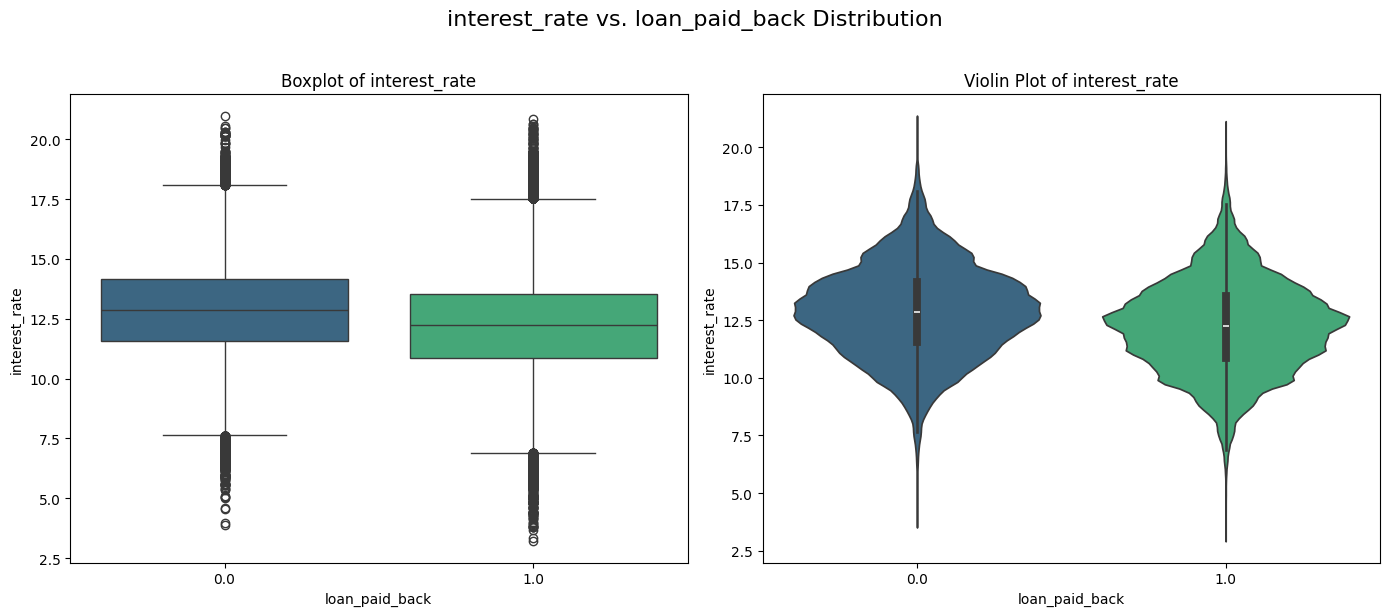

### Feature Signal Ranking

Top numeric (|Spearman|): [('debt_to_income_ratio', -0.2989567011574272), ('credit_score', 0.23768510761502679), ('interest_rate', -0.1307755257296675), ('annual_income', 0.011288023123160596), ('loan_amount', -0.005494673276791396)]
Top categorical (range of mean risk): [('employment_status', 0.9195855288257087, 5), ('grade_subgrade', 0.35299119137502977, 30), ('loan_purpose', 0.04617105284530865, 8), ('education_level', 0.04117491153106401, 5), ('marital_status', 0.009295935669552002, 4), ('gender', 0.006375555404476763, 3)]


In [26]:
run_data_visualization(training_df, target = TARGET, cat_count = 0)

## Test Dataset Visualization

In [27]:
run_data_visualization(test_df, target = TARGET, cat_count = 0)

Target not present → skipping target-aware plots.


## Original Dataset Visualization

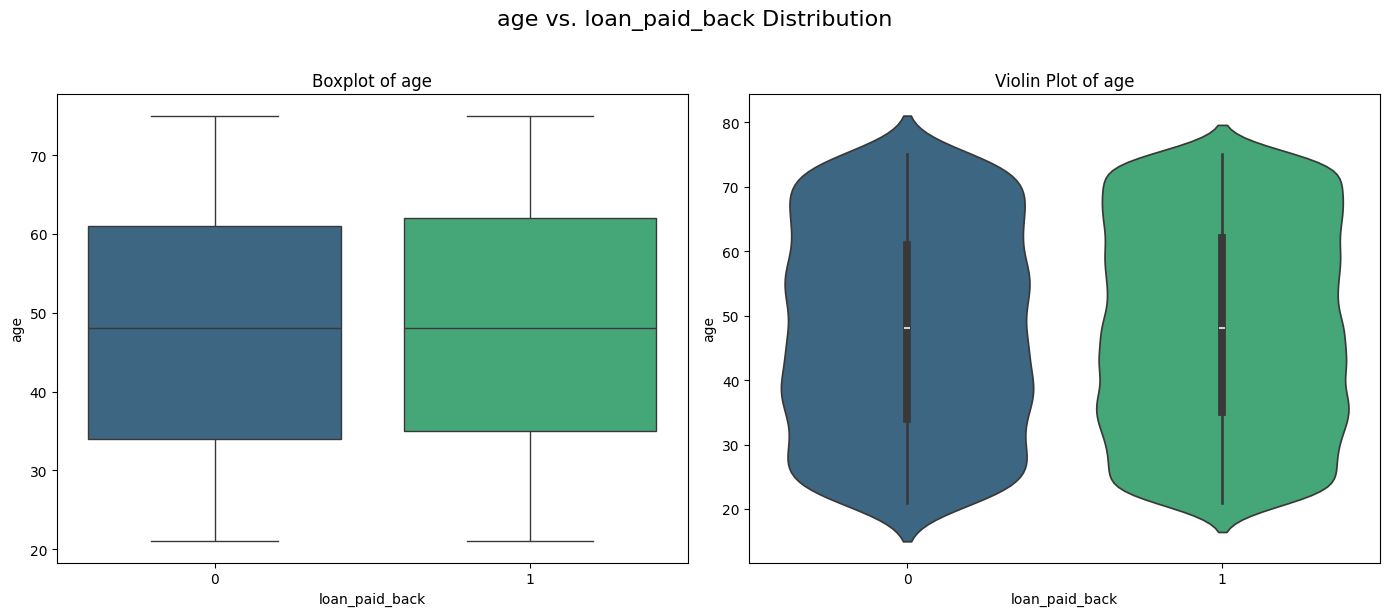

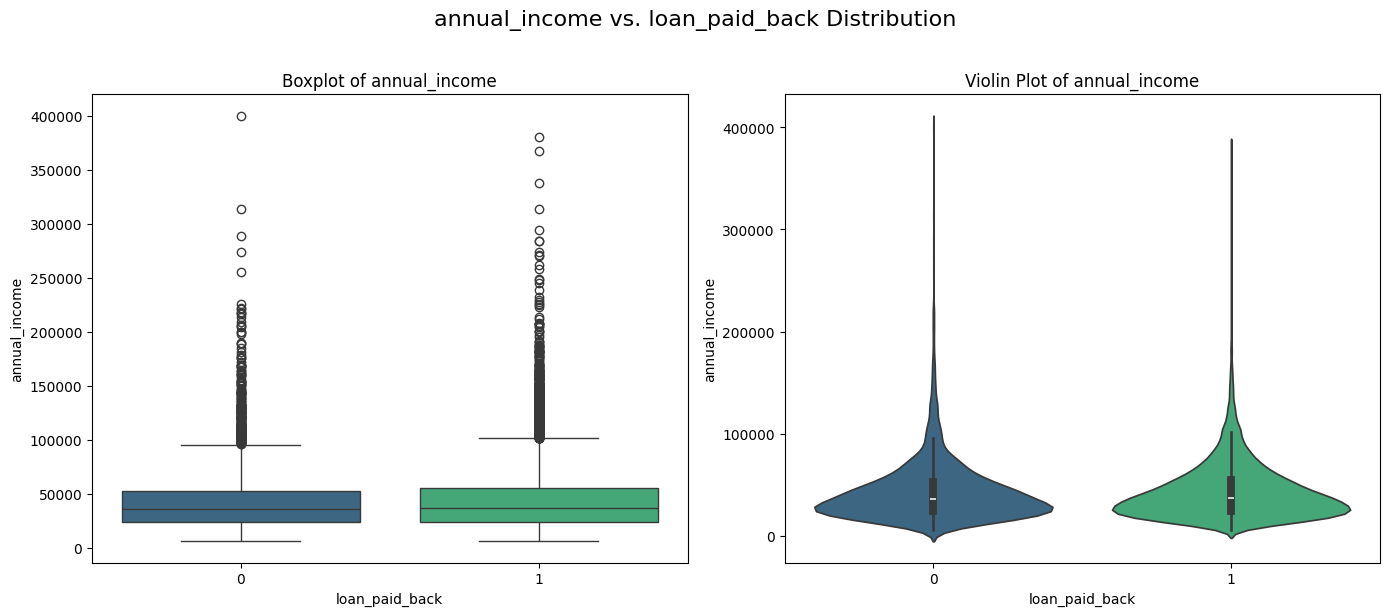

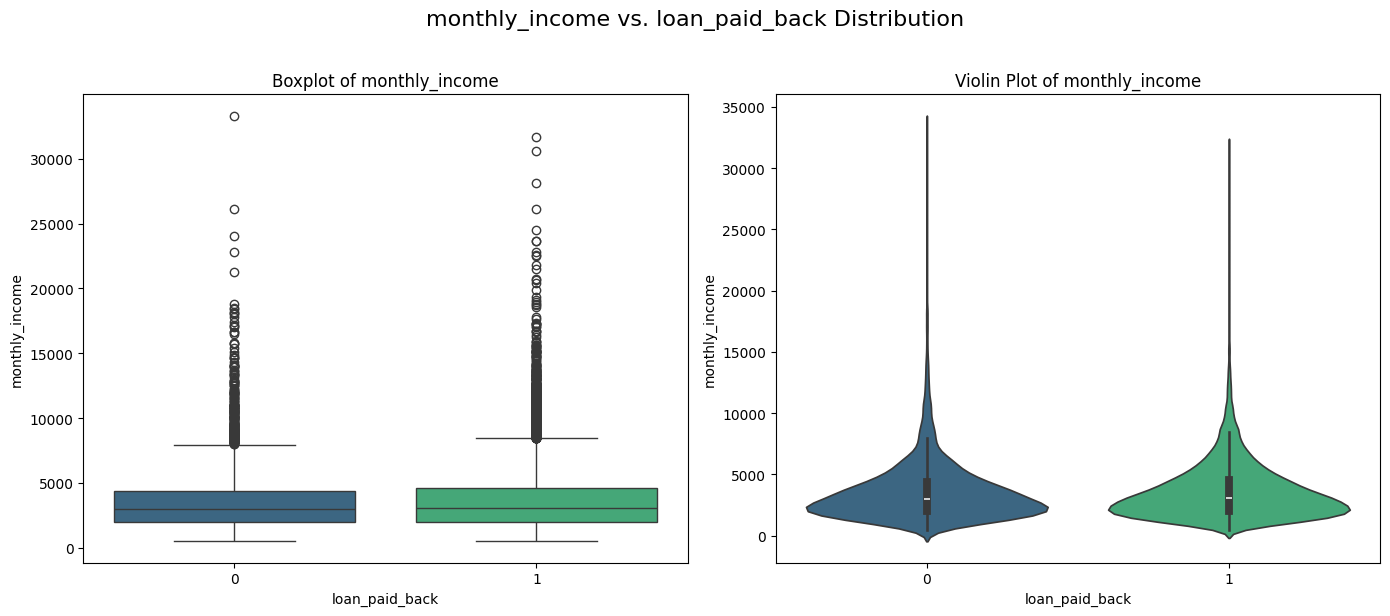

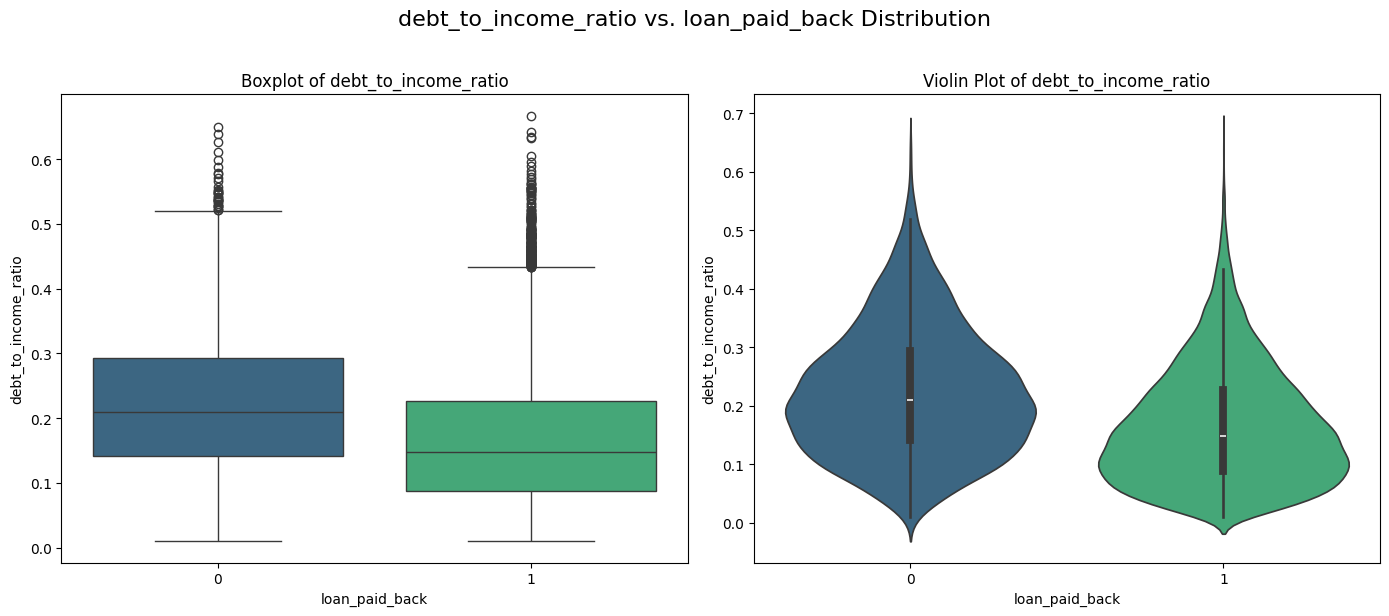

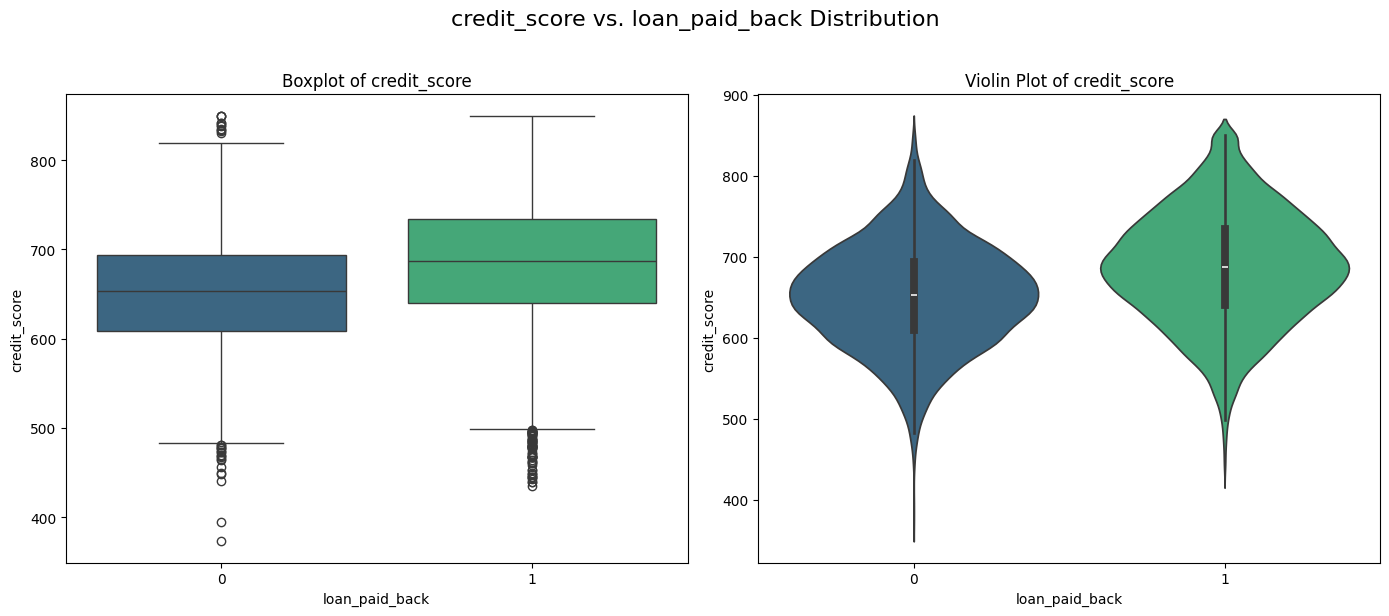

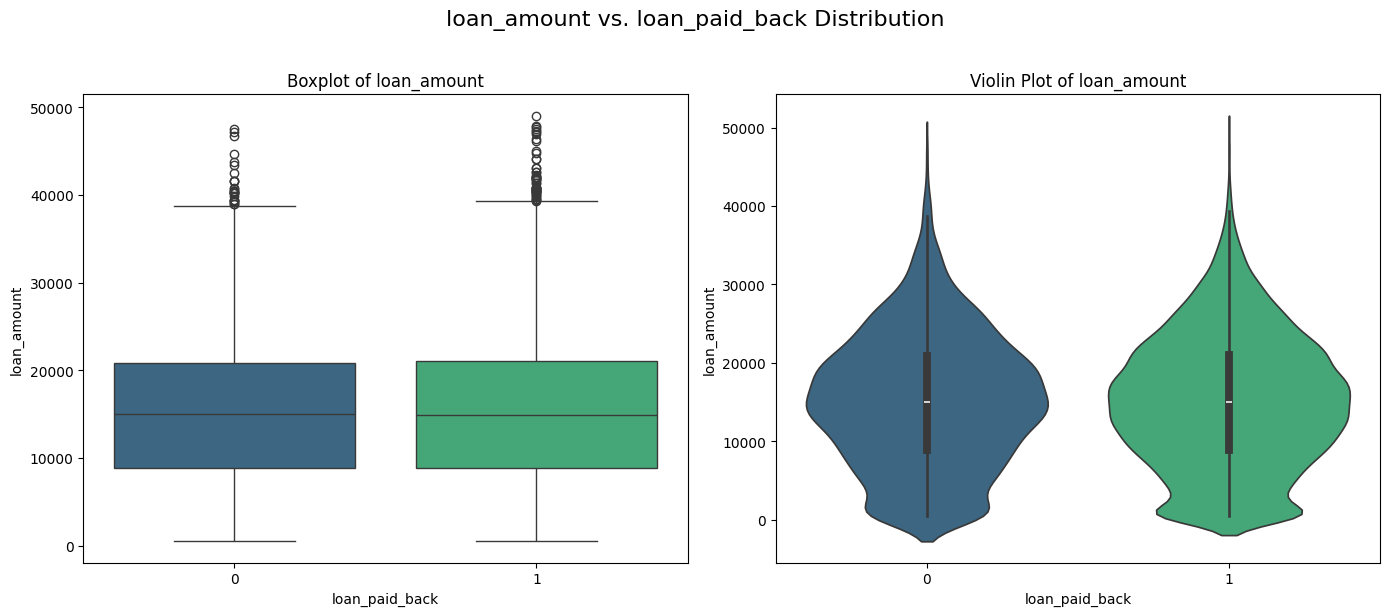

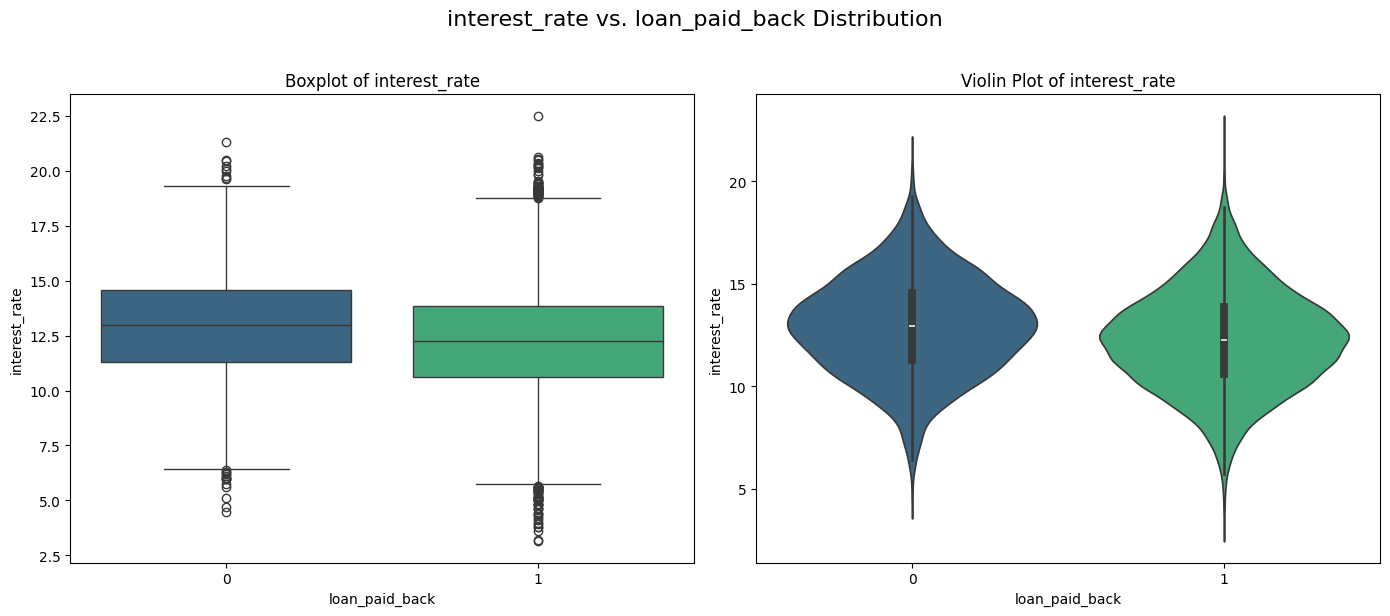

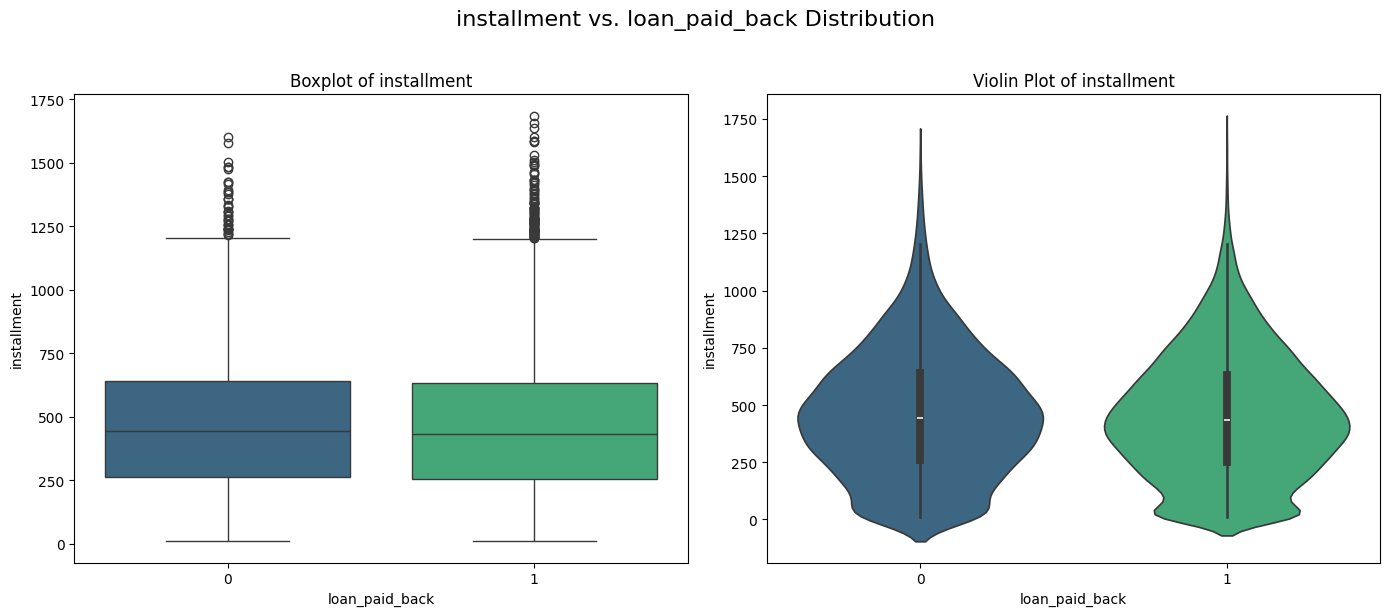

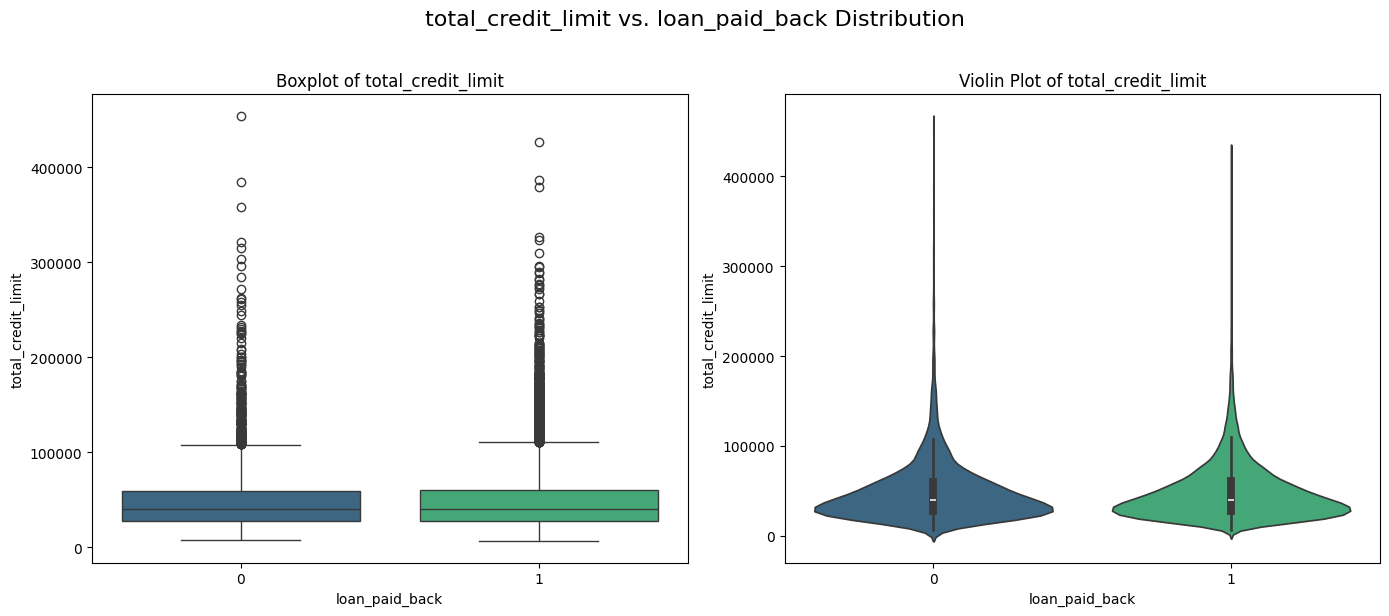

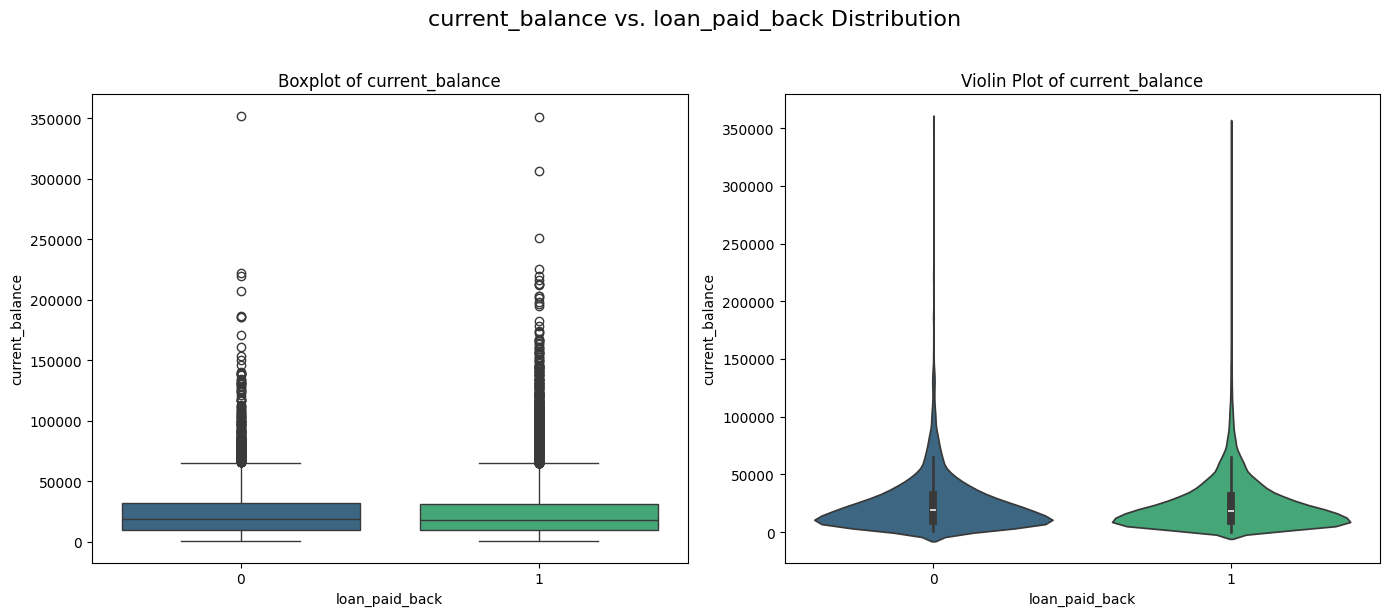

### Feature Signal Ranking

Top numeric (|Spearman|): [('debt_to_income_ratio', -0.22064939336755227), ('credit_score', 0.2013362416996396), ('interest_rate', -0.11208607413662355), ('delinquency_history', -0.08135033335712799), ('num_of_delinquencies', -0.06810106580509225), ('annual_income', 0.011273905537743963), ('monthly_income', 0.011273862245963027), ('installment', -0.009834408148448714), ('age', 0.00794321591237633), ('total_credit_limit', 0.0042603711399136724)]
Top categorical (range of mean risk): [('employment_status', 0.8131658247776158, 5), ('grade_subgrade', 0.3078167786905651, 30), ('loan_purpose', 0.04612606339499259, 8), ('education_level', 0.03705926551209149, 5), ('marital_status', 0.020489677352422464, 4), ('gender', 0.009448340757702844, 3)]


In [28]:
run_data_visualization(original_df, target = TARGET, cat_count = 0)

### Findings from Data Visualizations

Our deep dive using ydata_profiling and comparative analysis has moved beyond hypotheses to firm conclusions. These findings will directly shape our preprocessing and modeling strategy.

*    **Exceptional Data Quality:** The analysis confirms the data is of very high quality. The training, test, and even the original datasets are **100% complete, with no missing values.** This eliminates the need for any imputation and simplifies our preprocessing pipeline.

*    **Identified Class Imbalance:** The target variable, `loan_paid_back`, is binary and, as confirmed by our reports, exhibits a significant **class imbalance**. There are far more paid-back loans (class 1.0) than defaulted loans (class 0.0). This confirms that we must use an appropriate evaluation metric, like **AUC-ROC**, instead of simple accuracy.

*    **Confirmed Key Predictors:** The correlation matrices have verified that a few features have a strong predictive signal. The most important features, which are highly correlated with the target, are `interest_rate`, `credit_score`, `grade_subgrade`, and `employment_status`. Our feature engineering will be prioritized around these high-value predictors.

*    **Excellent Train-Test Consistency:** The comparison report between the `train` and `test` sets shows that their feature distributions are **nearly identical**. This is the ideal scenario, as it means our local cross-validation (CV) scores should be a very reliable proxy for our model's performance on the private leaderboard.

*    **Strategic Opportunity with Original Data:** Our comparison of the synthetic `train` and the `original` dataset also shows a high degree of similarity. This validates the quality of the synthetic data and presents a key strategic opportunity: we can likely **combine both datasets** to create a larger, more robust training set, which often leads to better model generalization.

## Feature Engineering

**TBD**